In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from common import Statistics, dataset_source
from resources.conv_learner import *
from resources.plots import *

In [ ]:
!ls

In [15]:
PATH = "datasets/yeast_v4.2/"
data_path = Path(PATH)

In [16]:
CLASSES = ('WT', 'mfb1KO', 'mfb1KO_mmr1KO', 'mmr1KO')
NUM_CLASSES = len(CLASSES)
BATCH_SIZE = 64
SIZE = 200

In [17]:
stats_name = "yeast_v4.2_per_class.dict"
test_dirs, train_dirs = dataset_source(data_path)
stats_dict = Statistics.per_class(test_dirs, train_dirs,save_name=stats_name)

working on: Cit1_MC_mfb1KO
working on: Cit1_MC_mfb1KO_mmr1KO
working on: Cit1_MC_mmr1KO
working on: Cit1_MC_WT


In [21]:
def get_data(path: str, sz, bs, stats):
    create, lbl2index = ImageClassifierData.prepare_from_path(path, val_name='test', test_name='yeast_v3_test_v1', test_with_labels=True, bs=bs)
    stats_dict = {lbl2index[key]: val for key, val in stats.items()}
    tfms = tfms_from_stats(stats_dict, sz, aug_tfms=[RandomDihedral()], pad=sz//8) #even without transformations and padding -> failure
    print('\n class to index mapping:\n',lbl2index)
    return create(tfms)

### the eventual sub-function of ImageClassifierData (read_dirs) expects subdirectories for each class: 
### e.g. all "test/cat.png" images should be in a "cat" folder. 

In [22]:
data = get_data(PATH,SIZE, BATCH_SIZE,stats_dict)


 class to index mapping:
 {'Cit1_MC_WT': 0, 'Cit1_MC_mfb1KO': 1, 'Cit1_MC_mfb1KO_mmr1KO': 2, 'Cit1_MC_mmr1KO': 3, 'Mfb1KO_175': 0, 'WT_175': 1, 'mmr1KO_240': 2}


In [23]:
x, y = next(iter(data.trn_dl))

In [24]:
print(np.array(x).shape)
type(y)

(64, 2, 200, 200)


torch.cuda.LongTensor

In [25]:
print(y.size())

torch.Size([64])


In [ ]:
idx = 30
tiff.imshow(data.trn_ds.denorm(x[idx], y[idx]).squeeze()[:,:,0]); #denorm function called has a rollaxis() hence indexing changes.

# Training setup

In [3]:
torch.cuda.is_available()

True

## ResNet_with_Batchnorm

In [26]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [27]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [28]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [29]:
wd=1e-5

In [30]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 4), data)

In [31]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 2, 200, 200]),
                           ('output_shape', [-1, 10, 200, 200]),
                           ('trainable', True),
                           ('nb_params', 510)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 200, 200]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 200, 200]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 100, 100]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('trainable', True),
                           ('nb_params', 3600)])),
             ('ResnetLayer-5',
     

In [16]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

[0]:  0.0%                                              
[1]:  0.0%
[2]:  0.0%
[3]:  1.0%
epoch      trn_loss   val_loss   accuracy   
    0      25.581697  30.493193  0.25      
[0]:  0.0%                                              
[1]: 0.5714%
[2]:  0.0%
[3]: 0.2571%
    1      18.428903  3.97645    0.157143  
[0]: 0.6571%                                            
[1]:  0.0%
[2]:  0.0%
[3]: 0.6286%
    2      12.323148  2.583577   0.271429  
[0]: 0.7143%                                            
[1]:  0.0%
[2]:  0.0%
[3]:  0.6%
    3      9.038193   2.245134   0.271429  
[0]:  0.0%                                              
[1]:  0.0%
[2]:  0.0%
[3]:  1.0%
    4      7.880948   3.536949   0.25      
[0]: 0.5429%                                            
[1]:  0.0%
[2]:  0.0%
[3]: 0.7429%
    5      6.712053   3.525544   0.307143  
[0]:  0.0%                                              
[1]: 0.02857%
[2]:  0.0%
[3]: 0.9714%
    6      5.612187   1.736191   0.242857  
[0]:

[array([1.2065]), 0.42142857228006636]

In [17]:
# at very little overfitting we have 43% accuracy
%time learn.fit(1e-2, 8, wds=wd, cycle_len=10, use_clr=(20,8, 0.95, 0.85), best_save_name='Objective_A_Resnet_per_class_1')

[0]: 0.7143%                                            
[1]: 0.7429%
[2]:  0.0%
[3]: 0.2571%
epoch      trn_loss   val_loss   accuracy   
    0      1.105697   1.193817   0.457143  
[0]:  0.6%                                              
[1]: 0.5143%
[2]: 0.3143%
[3]:  0.4%
    1      1.094214   1.135195   0.464286  
[0]:  0.6%                                              
[1]: 0.7429%
[2]: 0.02857%
[3]: 0.4571%
    2      1.091948   1.171005   0.457143  
[0]:  0.8%                                              
[1]:  0.6%
[2]:  0.0%
[3]: 0.4857%
    3      1.087722   1.183474   0.478571  
[0]: 0.6857%                                            
[1]: 0.6571%
[2]: 0.1714%
[3]:  0.4%
    4      1.071783   1.106331   0.478571  
[0]: 0.7429%                                            
[1]:  0.6%
[2]:  0.0%
[3]: 0.5143%
    5      1.065074   1.132733   0.492857  
[0]: 0.7143%                                            
[1]: 0.5143%
[2]:  0.0%
[3]: 0.6286%
    6      1.054835   1.143252   0

    58     0.675869   0.916484   0.657143  
[0]: 0.6857%                                             
[1]: 0.8571%
[2]: 0.1143%
[3]:  0.8%
    59     0.662394   0.846393   0.678571  
[0]:  0.8%                                               
[1]: 0.6857%
[2]: 0.1143%
[3]:  0.8%
    60     0.658014   0.896845   0.628571  
[0]: 0.9143%                                             
[1]:  0.8%
[2]: 0.1714%
[3]:  0.6%
    61     0.644373   1.013676   0.621429  
[0]: 0.8286%                                             
[1]:  0.6%
[2]: 0.2571%
[3]: 0.7143%
    62     0.651158   0.905012   0.628571  
[0]:  0.8%                                               
[1]: 0.7143%
[2]: 0.2286%
[3]: 0.7429%
    63     0.660707   0.830163   0.657143  
[0]: 0.7143%                                             
[1]: 0.4571%
[2]: 0.2857%
[3]: 0.8571%
    64     0.667207   0.992508   0.621429  
[0]: 0.7429%                                             
[1]: 0.8571%
[2]: 0.1714%
[3]: 0.6571%
    65     0.656517   0

[array([0.80839]), 0.6714285714285714]

In [18]:
%time learn.fit(1e-3, 8, wds=wd, cycle_len=20, use_clr=(20,8, 0.95, 0.85), best_save_name='Objective_A_Resnet_per_class_2')

[0]: 0.7714%                                             
[1]: 0.8286%
[2]: 0.1714%
[3]: 0.7714%
epoch      trn_loss   val_loss   accuracy   
    0      0.480705   0.785437   0.7       
[0]: 0.7714%                                             
[1]: 0.8571%
[2]: 0.2286%
[3]: 0.7714%
    1      0.478187   0.75729    0.728571  
[0]:  0.8%                                               
[1]:  0.8%
[2]: 0.1714%
[3]: 0.7143%
    2      0.482345   0.802023   0.685714  
[0]: 0.7714%                                             
[1]: 0.8286%
[2]: 0.1429%
[3]: 0.7429%
    3      0.478116   0.788046   0.692857  
[0]: 0.7429%                                             
[1]:  0.8%
[2]:  0.2%
[3]: 0.7714%
    4      0.468736   0.776927   0.707143  
[0]:  0.8%                                               
[1]: 0.8571%
[2]: 0.1714%
[3]: 0.7429%
    5      0.467146   0.789682   0.707143  
[0]: 0.7429%                                             
[1]: 0.8571%
[2]: 0.1714%
[3]: 0.7714%
    6      0.46611

    58     0.432166   0.77689    0.728571  
[0]:  0.8%                                               
[1]: 0.8286%
[2]: 0.1714%
[3]: 0.7714%
    59     0.430623   0.77896    0.728571  
[0]: 0.7714%                                             
[1]: 0.8286%
[2]: 0.2571%
[3]: 0.7143%
    60     0.430427   0.756697   0.707143  
[0]: 0.7714%                                             
[1]: 0.8857%
[2]: 0.2286%
[3]: 0.7143%
    61     0.428124   0.763286   0.714286  
[0]:  0.8%                                               
[1]: 0.7714%
[2]: 0.1429%
[3]: 0.7714%
    62     0.430638   0.79151    0.685714  
[0]: 0.7714%                                             
[1]:  0.8%
[2]: 0.2857%
[3]: 0.7714%
    63     0.429523   0.734173   0.735714  
[0]:  0.8%                                               
[1]: 0.8286%
[2]:  0.2%
[3]: 0.7714%
    64     0.425523   0.766349   0.721429  
[0]: 0.7714%                                             
[1]: 0.8571%
[2]: 0.2857%
[3]: 0.7429%
    65     0.4271

[array([0.78974]), 0.7]

In [37]:
learn.load('Objective_A_Resnet_per_class_2')

In [38]:
%time learn.fit(1e-3, 1, wds=wd, cycle_len=1, use_clr=(20,8, 0.95, 0.85))

  0%|                                                                                                                                                                                          | 0/9 [00:00<?, ?it/s][0]: 80.0%
[1]: 80.0%
[2]: 31.43%
[3]: 74.29%
EPOCH 0 ---------------                                                                                                                                                                                              
epoch      trn_loss   val_loss   accuracy   
    0      0.410266   0.788674   0.685714  

Wall time: 5.98 s


[array([0.78867]), 0.6857142874172756]

## Predictions

In [36]:
learn.load('Objective_A_Resnet_per_class_2')

In [39]:
log_testpreds = learn.predict(is_test=True)

In [40]:
testprobs = np.exp(log_testpreds[:,1])
testprobs

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.], dtype=float32)

## Analysis

In [78]:
log_preds, y = learn.TTA() # run predictions with TTA

### Confusion matrix

[[32  1  8  5]
 [ 1 32 10  5]
 [ 1  1  9  2]
 [ 1  1  8 23]]


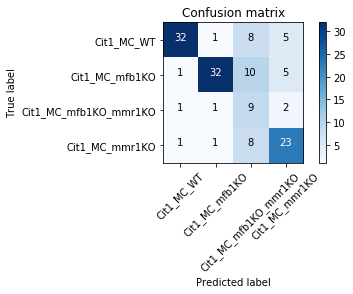

In [79]:
# Plot confusion matrix 
log_preds_mean = np.mean(log_preds, axis=0)
preds = np.argmax(log_preds_mean, axis=1)
cm = confusion_matrix(preds,y)
plot_confusion_matrix(cm, data.classes)

In [54]:
log_preds_mean.shape

(140, 4)

### Analyse images 

#### Show random correct/incorrectly classified images:

In [87]:
log_preds_mean = np.mean(log_preds, axis=0) # averages predictions on original + 4 TTA images
preds = np.argmax(log_preds_mean, axis=1) # converts into 0 or 1

In [88]:
# probs = np.exp(log_preds_mean[:,0]) # prediction(WT)
probs = np.exp(log_preds_mean) # predictions

In [89]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [90]:
def plots(ims, channel, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=11)
        if channel is not None: plt.imshow(ims[i,channel,:,:]) 
        else: plt.imshow(np.sum(ims, axis=1)[i,:,:])

In [91]:
def plot_val_with_title_from_ds_no_denorm(idxs, title, channel=None):
    
    imgs = np.stack(data.val_ds[x][0] for x in idxs) # get images by idx
    corr_lbl = np.stack(data.val_ds[x][1] for x in idxs) # get correct label from data.val_ds by idx
    pred_lbl = np.stack(preds[x] for x in idxs) # get predicted label from preds by idx
    p_max = [np.amax(probs[x,:]) for x in idxs] # get highes probability from probs by idx
    
    title_fin = [f"true = {corr_lbl[x]}\n predicted: {pred_lbl[x]}\n  p = {p_max[x]}" for x in corr_lbl]
    print(title)
    
    return plots(imgs, channel, rows=1, titles=title_fin, figsize=(16,8))

Correctly classified


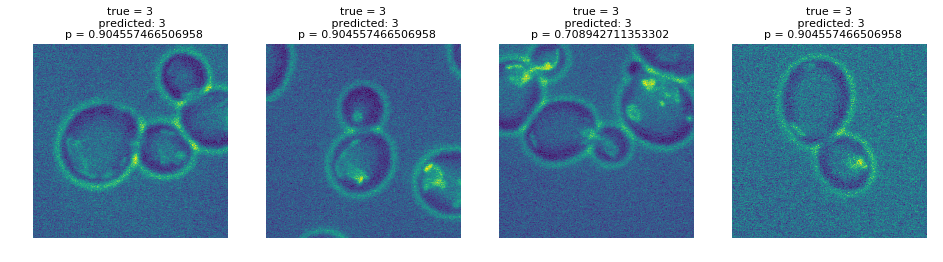

In [92]:
# load from ds - not denormalized! 
plot_val_with_title_from_ds_no_denorm(rand_by_correct(True), "Correctly classified")
#optionally pass channel arg. to select single channel

Incorrectly classified


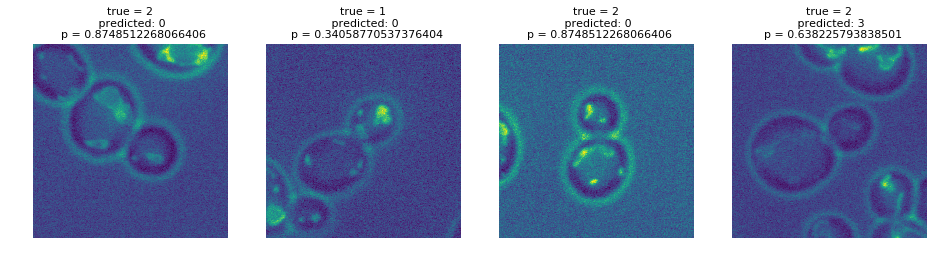

In [94]:
plot_val_with_title_from_ds_no_denorm(rand_by_correct(False), "Incorrectly classified")

#### Show most correct/incorrectly classified images per class:

In [95]:
def most_by_mask(mask, y, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[:,y][idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), y, mult)

Most correctly classified WT


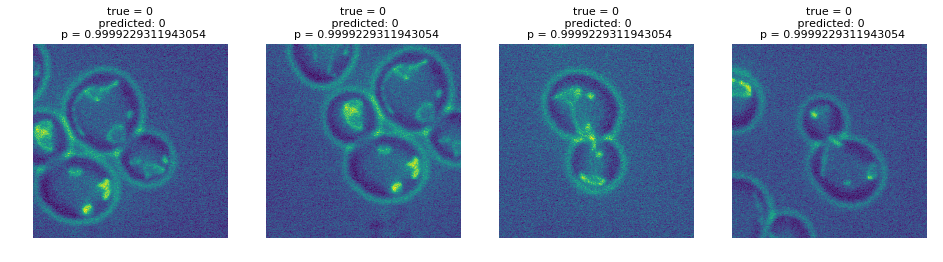

In [96]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(0, True), "Most correctly classified WT")

Most incorrectly classified WT


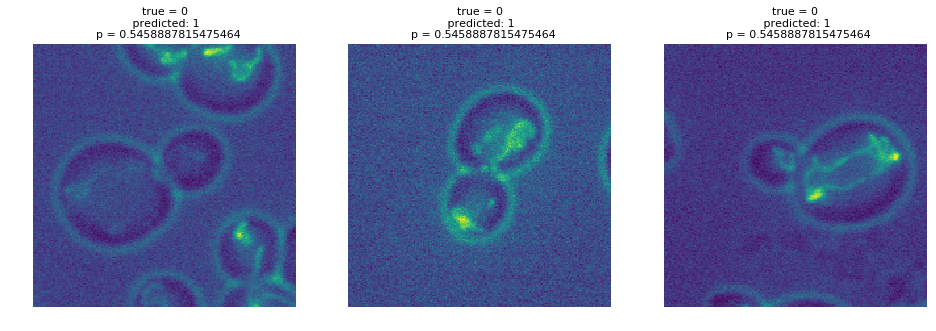

In [97]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(0, False), "Most incorrectly classified WT") # logic?

Most correctly classified mfb1KO


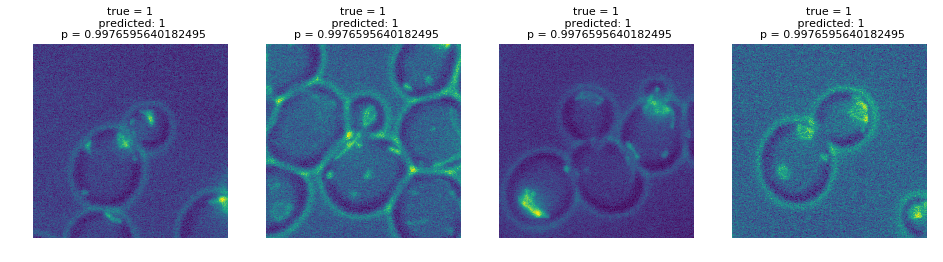

In [98]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(1, True), "Most correctly classified mfb1KO") 

Most incorrectly classified mfb1KO


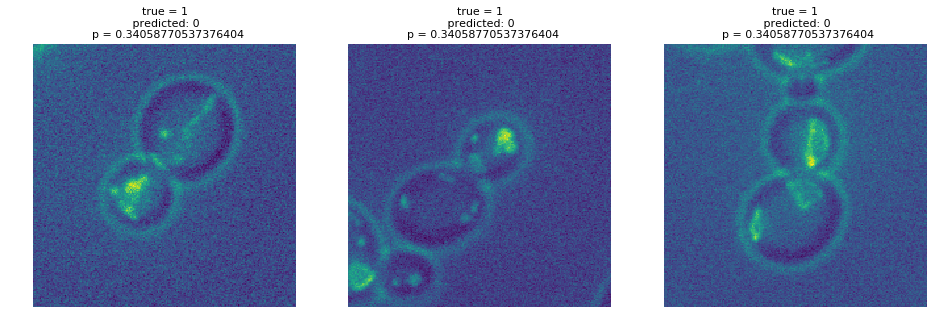

In [99]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(1, False), "Most incorrectly classified mfb1KO")

Most correctly classified mfb1KO-mmr1KO


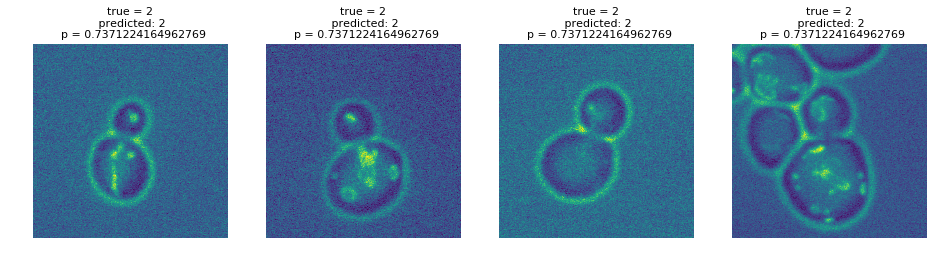

In [100]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(2, True), "Most correctly classified mfb1KO-mmr1KO")

Most correctly classified mmr1KO


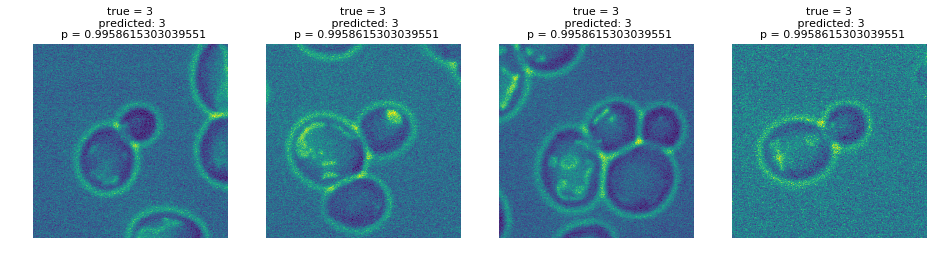

In [101]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(3, True), "Most correctly classified mmr1KO")

In [102]:
# etc.

#### Show (most) uncertain images

Most uncertain predictions


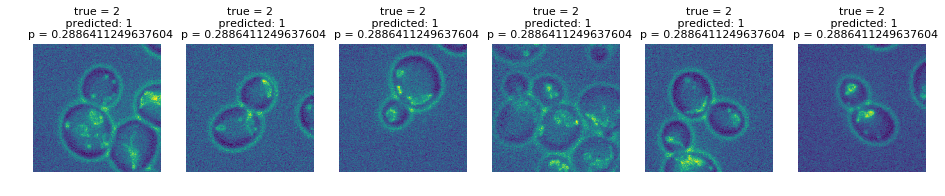

In [123]:
most_uncertain = t = np.argsort(np.amax(probs, axis = 1))[:6] # get best "guess" per image and list the least confident ones
plot_val_with_title_from_ds_no_denorm(most_uncertain, "Most uncertain predictions")